In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

import pickle as pk
from PIL import Image
import random

PyTorch Version:  1.0.0
Torchvision Version:  0.2.1


In [3]:
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections
import numpy
from nearpy.filters import NearestFilter


In [4]:
# Detect if we have a GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:',device)

batch_size = 32

device: cuda


In [5]:
# save to loacl file
# save_path = './features/maxPooling_UcRemote21-train-resnet'
save_path = './features/rmac_L=2_UcRemote21-train-resnet'

def save_data(file, data):
    f = open(file, 'wb+')
    pk.dump(data, f, 0)
    f.close()


def extract_features(model, loader):
    since = time.time()
    features = torch.FloatTensor()
         
    model.eval()

    # Iterate over data.
    for inputs, labels in loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        ff = outputs.data.cpu()
        # norm feature
        fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
        ff = ff.div(fnorm.expand_as(ff))
        features = torch.cat((features, ff), 0)

    time_elapsed = time.time() - since
    print('Feature extraction complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return features

if os.path.exists(save_path):
    fo = open(save_path, 'rb')
    features = pk.load(fo, encoding='bytes')
    fo.close()
    print("Load features.")
else:
    features = extract_features(pretrained_net, Gallery_loader)
    save_data(save_path, features)
    print("Save features to %s" % (save_path))

Load features.


In [6]:
features[0].shape

torch.Size([512])

In [7]:
# 提取目标图像的特征  修
def query_feature(input):
    x = input

    x = x.unsqueeze(dim=0)
    x.requires_grad = False

    x.to(device)
    pretrained_net.to('cpu')
    pretrained_net.eval()
    
    pre = pretrained_net(x)
    pre = pre.data.cpu()
    # norm feature
    prenorm = torch.norm(pre, p=2, dim=1, keepdim=True)
    pre = pre.div(prenorm.expand_as(pre))
    return pre

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def tensor2image(data):
    # 因为做了归一化，要返回标准tensor
    for i in range(len(data)): # (x-m)/s = y   x = 
        data[i] = data[i] * std[i] + mean[i]
    img = transforms.ToPILImage()(data).convert('RGB')
    plt.imshow(img)

In [9]:
# Dimension of our vector space
dimension = 512

# Create a random binary hash with 10 bits
rbp = RandomBinaryProjections('rbp', 0)

# Create engine with pipeline configuration
engine = Engine(dimension, lshashes=[rbp], vector_filters=[NearestFilter(21)])
# 计算目标图片与数据库中每张图像的余弦相似度
def ann_nearpy(query, features): 
    for i in range(len(features)):
        engine.store_vector(features[i], i)
    return engine.neighbours(query)

In [10]:
from torch.utils.data import Dataset, DataLoader
def dataLoader():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # mean = [0.485, 0.456, 0.406]  std = [0.229, 0.224, 0.225]
    test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])
    Gallery_dataset = datasets.ImageFolder(root='../数据集/UCMerced_LandUse/data/test', transform=test_augs)
#     Gallery_dataset = datasets.ImageFolder(root='../数据集/Google dataset of SIRI-WHU_earth_im_tiff/12class_tif', transform=test_augs)
    return Gallery_dataset
Gallery_dataset = dataLoader()
Gallery_loader = DataLoader(Gallery_dataset,
                           batch_size = 32, shuffle=False)

In [11]:
from graduation_pytorch.pooling import RMAC
## 得到训练好的网络模型
pretrained_net = models.resnet34(pretrained=True)
pretrained_net.avgpool = RMAC()
pretrained_net.fc = nn.Sequential()
PATH = "./my_model/rmac_L=2_UcRemote_resnet34_fine-tune.pt" # L其实=3
pretrained_net.load_state_dict(torch.load(PATH))

In [12]:
# 得到第一张图的feature
k = 46
query = query_feature(Gallery_dataset[k][0])
query = query.view(query.size(1))

In [13]:
# 得到邻近图片
query_numpy = query.numpy()
features_numpy = features.numpy()
near = ann_nearpy(query_numpy, features_numpy)

In [14]:
query_numpy.shape, features_numpy.shape

((512,), (420, 512))

In [17]:
1-near[20][2]

0.7586246143899262

In [14]:
    sim = []
    for data in near:
        sim.append(data[1])

In [15]:
# mAP... and  准确率 k = 5 10 20
def compute_AP_and_P(list, label):
    P_three = []
    true_size = 0.0
    AP = 0.0
    num = 1
    for i in range(len(list)):

        # 排除自身这张图片
        if i == 0:
            continue
        if list[i] == label:
            true_size += 1.
            AP += true_size / (i)
#             num = num + 1
        if i == 5:
            P_three.append(true_size/(i))
        if i == 10:
            P_three.append(true_size/(i))
        if i == 20:
            P_three.append(true_size/(i))
    if true_size == 0.0:
        return 0, [0,0,0]
    return AP/true_size, P_three

target label: 2
found label : 2 2 19 19 19 1 18 1 1 18 18 18 16 18 1 6 1 3 1 3 18 (1.0, [0.2, 0.1, 0.05])


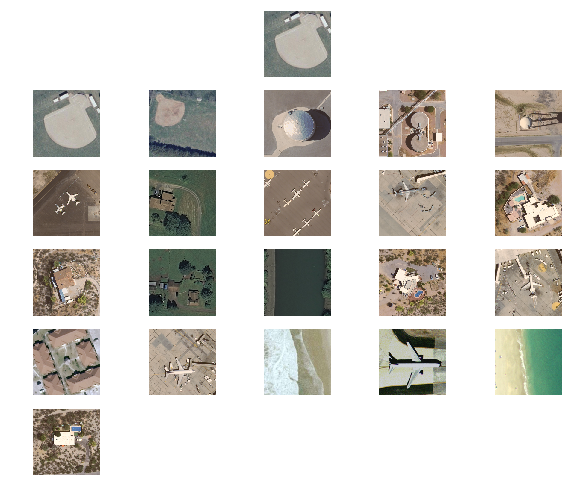

In [16]:
plt.subplots(figsize=(10, 10))
print("target label:",Gallery_dataset[k][1])
plt.subplot(7,5,3)
tensor2image(Gallery_dataset[k][0])
plt.axis('off')

preLabelList = []
i = 6
print('found label : ',end='')
for index in range(len(sim)):
    # 这里的index不需要从后数了
    re = sim[index]
    plt.subplot(7, 5, i)      
    tensor2image(Gallery_dataset[re][0])
    print('%s ' % (Gallery_dataset[re][1]),end='')
    preLabelList.append(Gallery_dataset[re][1])
    i += 1
    plt.axis('off')
print(compute_AP_and_P(preLabelList, Gallery_dataset[k][1]))
plt.show()

In [17]:
compute_AP_and_P(preLabelList, Gallery_dataset[k][1])

(1.0, [0.2, 0.1, 0.05])

In [ ]:
# mAP
import time
sum_AP = 0.0
P_three_sum = [0,0,0]
time_start = time.time()
for k in range(len(Gallery_dataset)): # 对所有图片进行搜索 420  21*20

#     k = random.randint(0, len(Gallery_dataset))  # 2400张图中随机选一张测试
    query = query_feature(Gallery_dataset[k][0])
    query = query.view(query.size(1))
    # 得到邻近图片
    query_numpy = query.numpy()
    features_numpy = features.numpy()
    near = ann_nearpy(query_numpy, features_numpy)
    
    # 得到结果的类别
    sim = []
    for data in near:
        sim.append(data[1])

    preLabelList = []
    for index in range(len(sim)):
        re = sim[index]
        preLabelList.append(Gallery_dataset[re][1])

    print(k)
    AP, P_three = compute_AP_and_P(preLabelList, Gallery_dataset[k][1])
    if k % 50 == 0:
        print('k: ', k ,'label: ', Gallery_dataset[k][1], 'AP: ', AP)
    sum_AP += AP
#     for i in range(3):
#         P_three_sum[i] += P_three[i]
time_end = time.time()
print('Time cost = %fs' % (time_end - time_start))
mAP = sum_AP / len(Gallery_dataset)
P_three_mean = [0,0,0]
for i in range(3):
    P_three_mean[i] = P_three_sum[i]/len(Gallery_dataset)

0
k:  0 label:  0 AP:  1.0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
k:  50 label:  2 AP:  1.0
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
k:  100 label:  5 AP:  1.0
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
k:  150 label:  7 AP:  1.0
151
152
153
154
155
156
157
158
159
160
161


In [37]:
mAP

0.9124652034430117

In [38]:
P_three_mean

[0.890476190476191, 0.8040476190476191, 0.6078571428571422]

## 计算查询时间

In [16]:
# 不计算精确度  只是查询

import time
time_start = time.time()
for k in range(len(Gallery_dataset)): # 对所有图片进行搜索 420  21*20
    
    if k % 10 == 0:
        print(k)

    query = query_feature(Gallery_dataset[k][0])
    query = query.view(query.size(1))
    # 得到邻近图片
    query_numpy = query.numpy()
    features_numpy = features.numpy()
    near = ann_nearpy(query_numpy, features_numpy)
    
    # 得到结果的序列号
    sim = []
    for data in near:
        sim.append(data[1])

    preLabelList = []
    for index in range(len(sim)):
        re = sim[index]
        preLabelList.append(Gallery_dataset[re][1])

time_end = time.time()
print('Time cost = %fs' % (time_end - time_start))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
Time cost = 203.401048s


In [1]:
174.38923/420

0.4152124523809524

In [ ]:
import time
sum_AP = 0.0
P_three_sum = [0,0,0]
time_start = time.time()
for k in range(len(Gallery_dataset)): # 对所有图片进行搜索 420  21*20
    query = query_feature(Gallery_dataset[k][0])
    query = pca.transform(query) # 对单个512=>32
    query = query.reshape(28)
    
    near_res = engine.neighbours(query)
    
    AP, P_three = compute_AP_and_P(near_res, Gallery_dataset[k][1])
    if k % 50 == 0:
        print('k: ', k ,'label: ', Gallery_dataset[k][1], 'AP: ', AP)
    sum_AP += AP
time_end = time.time()
print('Time cost = %fs' % (time_end - time_start))
mAP = sum_AP / len(Gallery_dataset)
P_three_mean = [0,0,0]
for i in range(3):
    P_three_mean[i] = P_three_sum[i]/len(Gallery_dataset)